<a href="https://colab.research.google.com/github/Parth-Bisht-227/Deep-Learning-Projects/blob/main/Dog_Cat_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dog - Cat Classifier Project in Deep Learning and ML**

In [1]:
!pip  install -q kaggle

In [2]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
100% 217M/218M [00:02<00:00, 130MB/s] 
100% 218M/218M [00:02<00:00, 109MB/s]


In [3]:
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [4]:
import os, glob, shutil
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torchvision.models import vgg16


In [5]:
#Creating the appropriate folder structure for the dataset images
TRAIN_DIRECTORY = '/content/training_set/training_set'
TEST_DIRECTORY = '/content/test_set/test_set'

TRAIN_CAT_DIRECTORY = '/content/training_set/training_set/cats'
TRAIN_DOG_DIRECTORY = '/content/training_set/training_set/dogs'
TEST_CAT_DIRECTORY = '/content/test_set/test_set/cats'
TEST_DOG_DIRECTORY = '/content/test_set/test_set/dogs'

def create_directories():
    try:
        os.mkdir(TRAIN_CAT_DIRECTORY)
        os.mkdir(TRAIN_DOG_DIRECTORY)
        os.mkdir(TEST_CAT_DIRECTORY)
        os.mkdir(TEST_DOG_DIRECTORY)
    except:
        pass


def move_to_respective_directories(
    source_folder,
    destination_folder,
    keyword
    ):
    for image_file_path in glob.glob(os.path.join(source_folder, '**')):
        try:
            image_file_name = os.path.basename(image_file_path)
            if keyword in image_file_name:
                shutil.move(
                    os.path.join(source_folder, image_file_name),
                    os.path.join(destination_folder, image_file_name)
                    )
        except:
            pass


create_directories()

move_to_respective_directories(TRAIN_DIRECTORY, TRAIN_CAT_DIRECTORY, 'cat')
move_to_respective_directories(TRAIN_DIRECTORY, TRAIN_DOG_DIRECTORY, 'dog')

move_to_respective_directories(TEST_DIRECTORY, TEST_CAT_DIRECTORY, 'cat')
move_to_respective_directories(TEST_DIRECTORY, TEST_DOG_DIRECTORY, 'dog')


In [6]:
dataset = ImageFolder('/content/training_set/training_set')
# splitting into train and val data
train_data, val_data, train_label, val_label = train_test_split(
    dataset.imgs, dataset.targets,
    test_size=0.1, random_state=42
)
# choosing gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The height and width of the cropped square image
IMAGE_SIZE = 224

class DogVsCatDataset(Dataset):
    def __init__(self, dataset, transform=None, IMAGE_SIZE=224):
        # choosing RGB images in the dataset
        self.dataset = self.is_channel_RGB(dataset)
        # the transformations we want to apply to the image
        self.transform = transform

    def __len__(self):
        '''
        to get the length of the dataset
        '''
        return len(self.dataset)


    def __getitem__(self, idx):
        '''
        to get the image and label, apply the transformation/augmentation
        '''
        image = Image.open(self.dataset[idx][0])
        label = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, label

    def collate_fn(self, batch):
        '''
        to preprocess images, labels before loading to training/validating
        '''
        imgs, labels = [], []
        for im, label in batch:
            # DEFINE preprocess functon defined
            # im = self.preprocess_image(im)
            imgs.append(im)

            labels.append(float(label))

        labels = torch.tensor(labels).to(device).float()
        imgs = torch.cat(imgs).to(device)
        imgs = imgs.view(-1,3,IMAGE_SIZE,IMAGE_SIZE)

        return imgs, labels

    def is_channel_RGB(self, dataset):
        '''
        Include only the images that has RGB channels in it. Exclude Rest.
        '''
        dataset_RGB = []
        for idx in range(len(dataset)):
            if (Image.open(dataset[idx][0]).getbands() == ("R", "G", "B")):
                dataset_RGB.append(dataset[idx])
        return dataset_RGB


# train transform
train_transform = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# val transform
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])


train_dataset = DogVsCatDataset(train_data, transform=train_transform, IMAGE_SIZE=IMAGE_SIZE)
val_dataset = DogVsCatDataset(val_data, transform=val_transform, IMAGE_SIZE=IMAGE_SIZE)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)


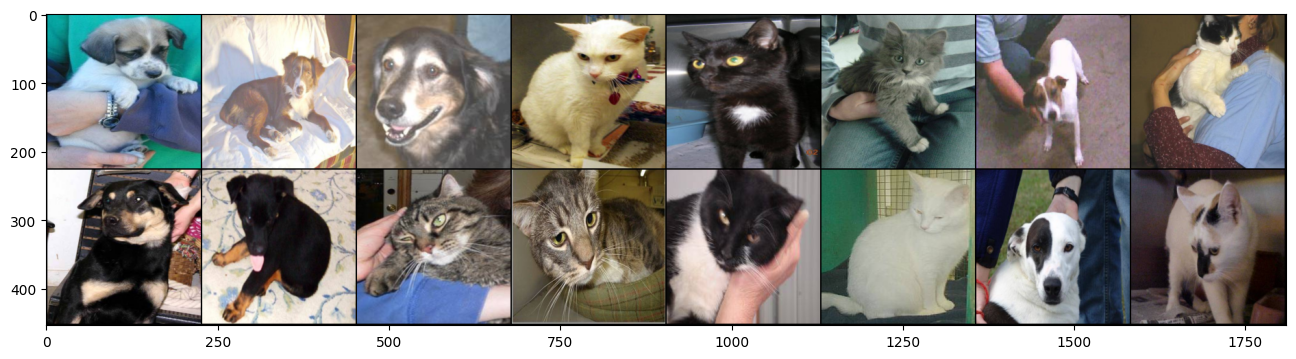

In [7]:
#visualising the Data
samples, labels =next(iter(DataLoader(train_dataset, batch_size=16, shuffle=True))) #next() --> _next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you must transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))


In [8]:
#using neural network VGG16


class DogVsCatClassifier(nn.Module):
    def __init__(self):
        super(DogVsCatClassifier, self).__init__()

        self.features_extracter = vgg16(pretrained=True).features
        self.avgpool = vgg16(pretrained=True).avgpool

        # we won't update these matrixes
        for param in self.features_extracter.parameters():
            param.requires_grad = False

        for param in self.avgpool.parameters():
            param.requires_grad = False


        self.classifier = nn.Sequential(

            nn.Flatten(),

            nn.Linear(in_features=25088, out_features=512, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),

            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),

            nn.Linear(in_features=256, out_features=32, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.4),

            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.features_extracter(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x



def find_error_in_model(NNmodel, IMAGE_SIZE, CHANNELS):
    # test the model
    model = NNmodel()
    try:
        # input the model with 2 RGB images randomly to test if it works
        model(torch.rand(2, CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
        print("Model has no Syntax or Math error")
    except Exception as e:
        print("Error: ", e)

find_error_in_model(DogVsCatClassifier, IMAGE_SIZE, 3)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.6MB/s]


Model has no Syntax or Math error


In [9]:
def get_model():
    model = DogVsCatClassifier()
    criterion = nn.BCELoss() # binary cross-entropy loss function
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) # optimizer

    return model.to(device), criterion, optimizer


model, criterion, optimizer = get_model()


def train_batch(data, model, optimizer, criteria):
    # activating training mode
    model.train()
    imgs, labels = data

    imgs = imgs.to(device)
    labels = labels.type(torch.FloatTensor)
    labels = labels.unsqueeze(1).to(device)
    # zero the gradients
    optimizer.zero_grad()
    pred_label = model(imgs)

    loss = criteria(pred_label, labels) # we calculate the loss

    # criterion = criteria(pred_label, labels)
    loss.backward()

    # criterion.backward()
    optimizer.step()

    return pred_label, loss # this fn returns predictions and loss as a tuple


# def validate_batch(data, model, criteria):
#     model.eval()

#     imgs, labels = data

#     imgs = imgs.to(device)
#     labels = labels.type(torch.FloatTensor)
#     labels = labels.unsqueeze(1).to(device)

#     with torch.no_grad():
#         pred_label = model(imgs)

#     criterion = criteria(pred_label, labels)

#     return criterion
def validate_batch(data, model, criteria):
    model.eval()
    imgs, labels = data
    with torch.no_grad():
        outputs = model(imgs.to(device))
        labels = labels.view(-1, 1).float()
        loss = criteria(outputs, labels.to(device))
    preds = (outputs > 0.5).float()
    return preds, loss




In [11]:

from sklearn.metrics import f1_score, accuracy_score

In [12]:
if __name__ == "__main__":
    import time
    from tqdm import tqdm
    from tqdm import trange

    model, criteria, optimizer = get_model()

    train_losses = []

    val_losses = []
    n_epochs = 5
    best_test_loss = 1000
    start = time.time()

    for epoch in trange(n_epochs, desc="Epoch : "):

        epoch_train_loss, epoch_val_loss = [], []
        epoch_train_f1_score, epoch_val_f1_score = [], []
        epoch_train_accuracy, epoch_val_accuracy = [], []

        _n = len(train_loader)
        correct = 0
        for ix, data in enumerate(tqdm(train_loader, position=0, leave=True)):
            preds, loss = train_batch(data, model, optimizer, criteria)
            epoch_train_loss.append(loss.item())
            imgs, labels = data
            preds = (model(imgs.to(device))>0.5).float()
            # correct += (preds == labels.to(device)).float().sum()
            # _, preds = torch.max(preds, 1)
            epoch_train_f1_score.append(f1_score(
        labels.cpu().detach().numpy(),
        preds.cpu().detach().numpy()))
            epoch_train_accuracy.append(accuracy_score(
        labels.cpu().detach().numpy(),
        preds.cpu().detach().numpy()))

        for ix, data in enumerate(tqdm(val_loader, position=0, leave=True)):
            preds, loss = validate_batch(data, model, criteria)
            epoch_val_loss.append(loss.item())
            imgs, labels = data
            preds = (model(imgs.to(device))>0.5).float()

            epoch_val_f1_score.append(f1_score(
        labels.cpu().detach().numpy(),
        preds.cpu().detach().numpy()))
            epoch_val_accuracy.append(accuracy_score(
        labels.cpu().detach().numpy(),
        preds.cpu().detach().numpy()))

        epoch_train_loss = sum(epoch_train_loss)/len(train_loader)
        epoch_val_loss = sum(epoch_val_loss)/len(val_loader)
        epoch_train_accuracy = sum(epoch_train_accuracy)/len(train_loader)
        epoch_val_accuracy = sum(epoch_val_accuracy)/len(val_loader)
        epoch_train_f1_score = sum(epoch_train_f1_score)/len(train_loader)
        epoch_val_f1_score = sum(epoch_val_f1_score)/len(val_loader)


        elapsed = time.time()-start
        print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(\
            epoch+1, n_epochs, time.time()-start, \
            (n_epochs-epoch)*(elapsed/(epoch+1)))
            )

        info = f'''
        \n
        \tEpoch: {epoch+1:03d}\
        \tTrain Loss: {epoch_train_loss:.3f}
        \tTrain Accuracy: {epoch_train_accuracy:.4f}
        \tTrain F1-Score: {epoch_train_f1_score:.3f}
        \Val Loss: {epoch_val_loss:.4f}
        \Val Accuracy: {epoch_val_accuracy:.3f}
        \Val F1-Score: {epoch_val_f1_score:.4f}
        '''

        print(info)


  0%|          | 0/401 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  2%|▏         | 9/401 [00:00<00:14, 27.58it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  4%|▎         | 15/401 [00:00<00:13, 27.69it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this beh

1/5 (109.15s - 545.77s remaining)

        

        	Epoch: 001        	Train Loss: 0.255
        	Train Accuracy: 0.9272
        	Train F1-Score: 0.924
        \Val Loss: 0.1670
        \Val Accuracy: 0.960
        \Val F1-Score: 0.6999
        


  1%|          | 3/401 [00:00<00:15, 25.43it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  2%|▏         | 9/401 [00:00<00:15, 24.90it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor pr

2/5 (218.97s - 437.95s remaining)

        

        	Epoch: 002        	Train Loss: 0.161
        	Train Accuracy: 0.9569
        	Train F1-Score: 0.955
        \Val Loss: 0.1615
        \Val Accuracy: 0.941
        \Val F1-Score: 0.7215
        


  0%|          | 0/401 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  1%|▏         | 6/401 [00:00<00:14, 27.57it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  3%|▎         | 12/401 [00:00<00:14, 27.21it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this beh

3/5 (332.92s - 332.92s remaining)

        

        	Epoch: 003        	Train Loss: 0.133
        	Train Accuracy: 0.9637
        	Train F1-Score: 0.961
        \Val Loss: 0.1074
        \Val Accuracy: 0.968
        \Val F1-Score: 0.6933
        


  0%|          | 0/401 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  1%|          | 3/401 [00:00<00:16, 24.49it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  3%|▎         | 12/401 [00:00<00:14, 26.92it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this beh

4/5 (443.85s - 221.93s remaining)

        

        	Epoch: 004        	Train Loss: 0.107
        	Train Accuracy: 0.9738
        	Train F1-Score: 0.971
        \Val Loss: 0.1245
        \Val Accuracy: 0.954
        \Val F1-Score: 0.6650
        


  1%|          | 3/401 [00:00<00:15, 24.98it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  2%|▏         | 9/401 [00:00<00:15, 24.84it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  4%|▎         | 15/401 [00:00<00:15, 25.28it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control 

5/5 (553.87s - 110.77s remaining)

        

        	Epoch: 005        	Train Loss: 0.102
        	Train Accuracy: 0.9741
        	Train F1-Score: 0.971
        \Val Loss: 0.1163
        \Val Accuracy: 0.963
        \Val F1-Score: 0.6816
        


In [13]:
# Saving the model (after solving errors)
torch.save(model.state_dict(), 'model.pth')
